In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler,OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import classification_report, precision_recall_curve, auc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch 
import os
import torch

import warnings
warnings.filterwarnings("ignore")

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print(device)

cuda


In [3]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTAB-GAN/Real_Datasets/train_category.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTAB-GAN/Real_Datasets/test_category.csv"
test_data = pd.read_csv(test_data_path)

## Load original data
fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTAB-GAN/Fake_Datasets/best.csv"
fake = pd.read_csv(fake_path, low_memory=False)

In [4]:
#keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']
keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
data_classification = data.copy()
test_classification = test_data.copy()
fake_classification = fake.copy()

data_classification = data_classification.drop(columns = keep_features)
test_classification = test_classification.drop(columns = keep_features)
fake_classification = fake_classification.drop(columns = keep_features)

In [5]:
## data Encoding
Labelencoding_features = ['term_months', 'sub_grade']
onehot_features = ['debt_settlement_flag', 'home_ownership', 'purpose']

onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

label_encoders = {}
for col in Labelencoding_features:
    le = LabelEncoder()
    data_classification[col] = le.fit_transform(data_classification[col])
    label_encoders[col] = le

# One-Hot Encoding
onehot_encoded = onehot_encoder.fit_transform(data_classification[onehot_features])
onehot_encoded_df = pd.DataFrame(
    onehot_encoded, 
    columns=onehot_encoder.get_feature_names_out(onehot_features),
    index=data_classification.index
)

# Merge
data_classification.drop(columns=onehot_features, inplace=True)
data_classification = pd.concat([data_classification, onehot_encoded_df], axis=1)

print("✅ Encoding 완료! 결과 shape:", data_classification.shape)

✅ Encoding 완료! 결과 shape: (1116458, 35)


In [6]:
##Fake data encoding
for col in Labelencoding_features:
    le = label_encoders[col]
    fake_classification[col] = le.transform(fake_classification[col])

# One-Hot Encoding (train에서 fit된 onehot_encoder 재사용)
onehot_encoded_test = onehot_encoder.transform(fake_classification[onehot_features])
onehot_encoded_test_df = pd.DataFrame(
    onehot_encoded_test,
    columns=onehot_encoder.get_feature_names_out(onehot_features),
    index=fake_classification.index
)

# Merge
fake_classification.drop(columns=onehot_features, inplace=True)
fake_classification = pd.concat([fake_classification, onehot_encoded_test_df], axis=1)

print("✅ 테스트 데이터 인코딩 완료! 결과 shape:", fake_classification.shape)

##Test data encoding
for col in Labelencoding_features:
    le = label_encoders[col]
    test_classification[col] = le.transform(test_classification[col])

# One-Hot Encoding (train에서 fit된 onehot_encoder 재사용)
onehot_encoded_test = onehot_encoder.transform(test_classification[onehot_features])
onehot_encoded_test_df = pd.DataFrame(
    onehot_encoded_test,
    columns=onehot_encoder.get_feature_names_out(onehot_features),
    index=test_classification.index
)

# Merge
test_classification.drop(columns=onehot_features, inplace=True)
test_classification = pd.concat([test_classification, onehot_encoded_test_df], axis=1)

print("✅ 테스트 데이터 인코딩 완료! 결과 shape:", test_classification.shape)

✅ 테스트 데이터 인코딩 완료! 결과 shape: (540000, 35)
✅ 테스트 데이터 인코딩 완료! 결과 shape: (744306, 35)


In [7]:
data_x = data_classification.drop(columns='loan_status')
data_y = data_classification[['loan_status']]

X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, train_size=0.8, test_size=0.2, random_state=42, stratify=data_y)

train_classification = pd.concat([X_train, y_train], axis=1)

In [8]:
from sklearn.utils import shuffle

train_data = pd.concat([train_classification, fake_classification])
train_data['loan_status'].value_counts()
train_data = shuffle(train_data, random_state=42)

In [9]:
X_train = train_data.drop(columns='loan_status')
y_train = train_data[['loan_status']]

X_test = test_classification.drop(columns='loan_status')
y_test = test_classification[['loan_status']]

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

model = XGBClassifier( 
    n_estimators=500,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42,
    verbose = True
)

[0]	validation_0-logloss:0.68622	validation_1-logloss:0.68434
[1]	validation_0-logloss:0.67942	validation_1-logloss:0.67765
[2]	validation_0-logloss:0.67276	validation_1-logloss:0.67109
[3]	validation_0-logloss:0.66625	validation_1-logloss:0.66469
[4]	validation_0-logloss:0.65984	validation_1-logloss:0.65839
[5]	validation_0-logloss:0.65357	validation_1-logloss:0.65223
[6]	validation_0-logloss:0.64741	validation_1-logloss:0.64618
[7]	validation_0-logloss:0.64135	validation_1-logloss:0.64024
[8]	validation_0-logloss:0.63543	validation_1-logloss:0.63443
[9]	validation_0-logloss:0.62961	validation_1-logloss:0.62872
[10]	validation_0-logloss:0.62388	validation_1-logloss:0.62312
[11]	validation_0-logloss:0.61829	validation_1-logloss:0.61763
[12]	validation_0-logloss:0.61279	validation_1-logloss:0.61225
[13]	validation_0-logloss:0.60739	validation_1-logloss:0.60697
[14]	validation_0-logloss:0.60210	validation_1-logloss:0.60179
[15]	validation_0-logloss:0.59689	validation_1-logloss:0.59670
[1

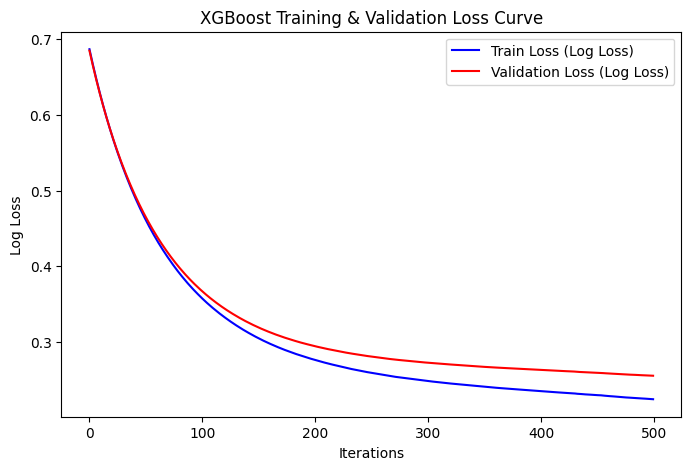

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93    599114
           1       0.66      0.90      0.76    145192

    accuracy                           0.89    744306
   macro avg       0.81      0.89      0.84    744306
weighted avg       0.91      0.89      0.89    744306



In [11]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
#y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

In [12]:
def encode_features(df, label_encoders, onehot_encoder, label_cols, onehot_cols):
    df = df.copy()
    
    # Label Encoding
    for col in label_cols:
        le = label_encoders[col]
        df[col] = le.transform(df[col])

    # One-Hot Encoding
    onehot_encoded = onehot_encoder.transform(df[onehot_cols])
    onehot_df = pd.DataFrame(
        onehot_encoded, 
        columns=onehot_encoder.get_feature_names_out(onehot_cols),
        index=df.index
    )

    df.drop(columns=onehot_cols, inplace=True)
    df = pd.concat([df, onehot_df], axis=1)
    
    return df

In [64]:
summary_with_sharpe = []

def linear_portfolio(top_10_indices, threshold):
    selected = test_data.loc[top_10_indices.index].copy()
    returns = (selected['total_pymnt_inv'] - selected['funded_amnt']) / selected['funded_amnt']
    
    avg_return = returns.mean()
    std_return = returns.std()
    sharpe_ratio = avg_return / std_return if std_return != 0 else np.nan

    summary_with_sharpe.append({
        'Average Return': avg_return * 100,
        'Std Dev': std_return,
        'Sharpe Ratio': sharpe_ratio,
        "Threshold": threshold
    }) 

In [14]:
drop2 = ['loan_status', 'return']

scaler = StandardScaler()
reg = LinearRegression()

fully_paid_indices = (y_pred == 0)
test_regression = test_data[fully_paid_indices]
test_regression['return'] = (test_regression['total_pymnt_inv'] - test_regression['funded_amnt'])/(test_regression['funded_amnt']+1e-8)

train_regression = data.copy()
train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['funded_amnt'])/train_regression['funded_amnt']

drop_features = ['loan_status', 'total_pymnt_inv', 'total_pymnt','funded_amnt','grade','loan_amnt']
train_regression = train_regression.drop(columns=drop_features)
test_regression = test_regression.drop(columns=drop_features)

fake_regression = fake.copy()
fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['funded_amnt'])/fake_regression['funded_amnt']
fake_regression = fake_regression.drop(columns=drop_features)

train_total_reg = pd.concat([train_regression, fake_regression])

########## Encoding categorical data ######################
train_total_reg = encode_features(train_total_reg, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

data_x_reg = train_total_reg.drop(columns='return')
data_y_reg = train_total_reg[['return']]

test_x = test_regression.drop(columns = 'return')
test_y = test_regression[['return']]

data_x_reg_scaled = scaler.fit_transform(data_x_reg)

X_train_reg = data_x_reg_scaled
y_train_reg = data_y_reg

test_x_scaled = scaler.transform(test_x)

reg.fit(X_train_reg, y_train_reg)

#print(reg.coef_)
y_pred_reg = reg.predict(test_x_scaled)

print("RMSE:", mean_squared_error(test_y, y_pred_reg, squared=False))
print("R²:", r2_score(test_y, y_pred_reg))

test_regression['predicted_return'] = reg.predict(test_x_scaled)

# y_pred가 0인 Fully Paid 대상 중
# 상위 10% 수익률이지만 std 너무 큰 예측은 제외
#top_10 = test_regression[test_regression['predicted_return'] <= test_regression['predicted_return'].quantile(0.99)]

# 예측 수익률이 너무 극단적인 애들 제거 (예: > Q99.5)
#max_threshold = test_regression['predicted_return'].quantile(0.999)
#top_10 = test_regression[test_regression['predicted_return'] <= max_threshold]
#top_10_percent = top_10.sort_values(by='predicted_return', ascending=False).head(int(len(top_10)*0.1))
top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.1))

linear_portfolio(top_10_percent, 0)

RMSE: 0.18435111569061935
R²: -0.2864854187728083


In [15]:
returns_with_sharpe_df = pd.DataFrame(summary_with_sharpe)

returns_with_sharpe_df.tail(10)

,Average Return,Std Dev,Sharpe Ratio,Threshold
0,16.189845,0.124527,1.300104,0


In [16]:
# total_pymnt_inv - funded_amnt의 평균값 계산
mean_diff = (fake['loan_amnt'] - fake['funded_amnt']).max()

print(f"✅ 평균 수익금액 (total_pymnt_inv - total_pymnt): {mean_diff:.4f}")


✅ 평균 수익금액 (total_pymnt_inv - total_pymnt): 38200.0000


In [17]:
data_label1 = data[data['loan_status'] == 1]

mean_diff_original = (data_label1['loan_amnt'] - data_label1['funded_amnt']).max()
print(f"✅ 평균 수익금액 (total_pymnt_inv - total_pymnt): {mean_diff_original:.4f}")

✅ 평균 수익금액 (total_pymnt_inv - total_pymnt): 17150.0000


In [14]:
def MLR_portfolio(fake, threshold):

    drop2 = ['loan_status', 'return']

    scaler = StandardScaler()
    reg = LinearRegression()

    fully_paid_indices = (y_pred == 0)
    test_regression = test_data[fully_paid_indices]
    test_regression['return'] = (test_regression['total_pymnt_inv'] - test_regression['funded_amnt'])/(test_regression['funded_amnt']+1e-8)

    train_regression = data.copy()
    train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['funded_amnt'])/train_regression['funded_amnt']

    drop_features = ['loan_status', 'total_pymnt_inv', 'total_pymnt','funded_amnt','grade','loan_amnt']
    train_regression = train_regression.drop(columns=drop_features)
    test_regression = test_regression.drop(columns=drop_features)

    fake_regression = fake.copy()
    fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['funded_amnt'])/fake_regression['funded_amnt']
    fake_regression = fake_regression.drop(columns=drop_features)

    train_total_reg = pd.concat([train_regression, fake_regression])

    ########## Encoding categorical data ######################
    train_total_reg = encode_features(train_total_reg, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
    test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

    data_x_reg = train_total_reg.drop(columns='return')
    data_y_reg = train_total_reg[['return']]

    test_x = test_regression.drop(columns = 'return')
    test_y = test_regression[['return']]

    data_x_reg_scaled = scaler.fit_transform(data_x_reg)

    X_train_reg = data_x_reg_scaled
    y_train_reg = data_y_reg

    test_x_scaled = scaler.transform(test_x)

    reg.fit(X_train_reg, y_train_reg)

    #print(reg.coef_)
    y_pred_reg = reg.predict(test_x_scaled)

    print("RMSE:", mean_squared_error(test_y, y_pred_reg, squared=False))
    print("R²:", r2_score(test_y, y_pred_reg))

    test_regression['predicted_return'] = reg.predict(test_x_scaled)

    """# y_pred가 0인 Fully Paid 대상 중
    # 상위 10% 수익률이지만 std 너무 큰 예측은 제외
    top_10 = test_regression[test_regression['predicted_return'] >= test_regression['predicted_return'].quantile(0.99)]

    # 예측 수익률이 너무 극단적인 애들 제거 (예: > Q99.5)
    max_threshold = test_regression['predicted_return'].quantile(0.995)
    top_10 = top_10[top_10['predicted_return'] <= max_threshold]
    top_10_percent = top_10.sort_values(by='predicted_return', ascending=False).head(int(len(top_10)*0.1))"""
    top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.1))

    linear_portfolio(top_10_percent, threshold)

In [15]:
## 수익률이 5%이상 받은 샘플 확인
# 수익률 500% 이하인 샘플 필터링
filtered_samples = fake[fake['total_pymnt_inv'] / (fake['funded_amnt']) <= 100]

filtered_samples['return'] = (
    filtered_samples['total_pymnt_inv'] - filtered_samples['funded_amnt']
) / (filtered_samples['funded_amnt'])

# 수익률 높은 순으로 확인
filtered_samples_sorted = filtered_samples.sort_values(by='return', ascending=False)

num_above_max = (filtered_samples_sorted['return'] > 1.17).sum()

print(f"✅ 수익률이 1.17보다 높은 합성 샘플 수: {num_above_max}")
# 상위 5개 예시 확인
print(filtered_samples_sorted[['funded_amnt', 'total_pymnt_inv', 'return']].head())


✅ 수익률이 1.17보다 높은 합성 샘플 수: 16682
        funded_amnt  total_pymnt_inv     return
264445       1000.0         61947.53  60.947530
346203       1100.0         61947.53  55.315936
394992       1000.0         55606.01  54.606010
455288       1000.0         50929.34  49.929340
537440       1000.0         50218.12  49.218120


In [18]:
## filtered_data 지우고
fake_data = fake.copy()

outlier_indices = filtered_samples_sorted[filtered_samples_sorted['return'] > 1.17].index

fake_data = fake_data.drop(index=outlier_indices).reset_index(drop=True)

MLR_portfolio(fake_data, threshold=2)

RMSE: 0.19407752243179408
R²: -0.4258170589306636


In [27]:
## return의 최댓값을 잘라낸다.
 
fake_data = fake.copy()

fake_data['return'] = (fake_data['total_pymnt_inv']-fake_data['funded_amnt'])/fake_data['funded_amnt']

upper_limit = fake_data['return'].quantile(0.9)
fake_data['return'] = np.where(fake_data['return'] > upper_limit, upper_limit, fake_data['return'])

fake_data = fake_data.drop(columns='return')

MLR_portfolio(fake_data, threshold=30)

RMSE: 0.18435111569061935
R²: -0.2864854187728083


In [36]:
def smooth_pymnt_fund(p, f):
    """수익률이 너무 크거나 작아지는 것을 방지하도록 raw 값을 스무딩"""
    r = (p - f) / (f + 1e-6)
    if r > 5:
        r = 3 + np.tanh(r - 3) * 0.5
    elif r < -1:
        r = -1 + np.tanh(r + 1) * 0.2
    return f, f * (1 + r)

def smooth_pymnt_fund_v2(p, f):
    r = (p - f) / (f + 1e-6)
    # 상한과 하한 모두 더 타이트하게
    if r > 3:
        r = 2.2 + np.tanh(r - 2.2) * 0.3  # 기존보다 덜 급등
    elif r < -0.5:
        r = -0.5 + np.tanh(r + 0.5) * 0.1
    return f, f * (1 + r)

fake_data = fake.copy()

# total_pymnt_inv 및 funded_amnt 스무딩 적용
smoothed_fund_pymnt = [smooth_pymnt_fund_v2(p, f) for p, f in zip(fake_data['total_pymnt_inv'], fake_data['funded_amnt'])]
fake_data['funded_amnt'], fake_data['total_pymnt_inv'] = zip(*smoothed_fund_pymnt)

# 필요한 경우 total_pymnt, loan_amnt도 동일한 방식 적용
# smoothed_loan_pymnt = [smooth_pymnt_fund(p, l) for p, l in zip(fake_data['total_pymnt'], fake_data['loan_amnt'])]
# fake_data['loan_amnt'], fake_data['total_pymnt'] = zip(*smoothed_loan_pymnt)

# 포트폴리오 평가
MLR_portfolio(fake_data, threshold=50)


RMSE: 0.17863872924987018
R²: -0.20799342105415186


In [ ]:
def hybrid_return_smoother(p, f):
    r = (p - f) / (f + 1e-6)
    if r > 5.0:  # 이상치 컷
        return None
    if r > 3:
        r = 2.5 + np.tanh(r - 2.5) * 0.3
    elif r < -0.5:
        r = -0.5 + np.tanh(r + 0.5) * 0.1
    return f, f * (1 + r)

def soft_pull_return(p, f):
    r = (p - f) / (f + 1e-6)
    # 중간 지점 중심으로 당김
    if r > 5:
        r = 3.5 + np.tanh((r - 3.5) / 2) * 0.5  # 완만하게 제한
    elif r < -0.5:
        r = -0.5 + np.tanh((r + 0.5) / 1) * 0.2  # 음수 수익률 완화
    return f, f * (1 + r)

# 적용
fake_data = fake.copy()
results = [hybrid_return_smoother(p, f) for p, f in zip(fake_data['total_pymnt_inv'], fake_data['funded_amnt'])]

# 제거된 데이터 제외
results_filtered = [x for x in results if x is not None]
funded_amnt_adj, pymnt_adj = zip(*results_filtered)

fake_data = fake_data.loc[[i for i, x in enumerate(results) if x is not None]].copy()
fake_data['funded_amnt'] = funded_amnt_adj
fake_data['total_pymnt_inv'] = pymnt_adj

# 평가
MLR_portfolio(fake_data, threshold=50)


RMSE: 0.1795536890005434
R²: -0.22039941904256044


In [40]:
def soft_pull_return(p, f):
    r = (p - f) / (f + 1e-6)
    # 중간 지점 중심으로 당김
    if r > 5:
        r = 3.5 + np.tanh((r - 3.5) / 2) * 0.5  # 완만하게 제한
    elif r < -0.5:
        r = -0.5 + np.tanh((r + 0.5) / 1) * 0.2  # 음수 수익률 완화
    return f, f * (1 + r)

# 적용
fake_data = fake.copy()
adjusted = [soft_pull_return(p, f) for p, f in zip(fake_data['total_pymnt_inv'], fake_data['funded_amnt'])]
funded_amnt_adj, pymnt_adj = zip(*adjusted)

fake_data['funded_amnt'] = funded_amnt_adj
fake_data['total_pymnt_inv'] = pymnt_adj

# 평가
MLR_portfolio(fake_data, threshold=50)


RMSE: 0.17830772845079934
R²: -0.20352097154632287


In [41]:
returns_with_sharpe_df = pd.DataFrame(summary_with_sharpe)

returns_with_sharpe_df.head(10)

,Average Return,Std Dev,Sharpe Ratio,Threshold
0,16.041674,0.123936,1.294348,50
1,16.281423,0.126796,1.284064,50
2,16.211143,0.125975,1.286857,50
3,16.366803,0.126710,1.291674,50


In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

def targeted_high_return_smoothing(fake_df):
    df = fake_df.copy()

    # 1. return 계산
    df['return'] = (df['total_pymnt_inv'] - df['funded_amnt']) / df['funded_amnt']

    # 2. KMeans 클러스터링
    kmeans = KMeans(n_clusters=3, random_state=42)
    df['cluster'] = kmeans.fit_predict(df[['return']])

    # 3. high cluster 식별
    cluster_means = df.groupby('cluster')['return'].mean()
    high_cluster = cluster_means.idxmax()

    # 4. high_cluster 내부에서 이상치만 조정
    high_df = df[df['cluster'] == high_cluster]
    high_mean = high_df['return'].mean()
    high_std = high_df['return'].std()

    high_idx = high_df[
        high_df['return'] > (high_mean + 1.5 * high_std)
    ].index

    # 5. soft pull 함수
    def soft_cap(r, cap=5):
        return cap + np.tanh(r - cap)   # cap 기준으로 완만히 조정

    # 6. 적용
    for i in high_idx:
        row = df.loc[i]
        adjusted_r = soft_cap(row['return'])
        df.at[i, 'total_pymnt_inv'] = row['funded_amnt'] * (1 + adjusted_r)

    df.drop(columns=['return', 'cluster'], inplace=True)
    return df
    


In [61]:
adjusted_fake = targeted_high_return_smoothing(fake)
MLR_portfolio(adjusted_fake, threshold=50)


RMSE: 0.18485992946895985
R²: -0.29359668398074557


In [71]:
def smooth_total_pymnt_inv(inv, funded, cap=3.5, floor=-1.2):
    r = (inv - funded) / funded

    # 상단 스무딩
    if r > cap:
        r = cap + np.tanh(r - cap) * 0.15

    # 하단 스무딩
    if r < floor:
        r = floor + np.tanh(r - floor) * 0.2

    return funded * (1 + r)  # 새로운 inv 값

# 🔁 적용
fake_data = fake.copy()
fake_data['total_pymnt_inv'] = fake_data.apply(
    lambda row: smooth_total_pymnt_inv(row['total_pymnt_inv'], row['funded_amnt']),
    axis=1
)


# ✅ 테스트
MLR_portfolio(fake_data, threshold=50)


RMSE: 0.18645666323648413
R²: -0.3160401637831556


In [72]:
returns_with_sharpe_df = pd.DataFrame(summary_with_sharpe)

returns_with_sharpe_df.head(10)

,Average Return,Std Dev,Sharpe Ratio,Threshold
0,16.044588,0.123957,1.294369,50
1,16.191650,0.124539,1.300124,50
2,16.024708,0.124013,1.292184,50


In [157]:
fake_data = fake.copy()

# 1. funded_amnt 하한 제한
fake_data['funded_amnt'] = fake_data['funded_amnt'].clip(lower=1000)

# 2. loan_amnt과 funded_amnt 평균 수렴
gap = np.abs(fake_data['loan_amnt'] - fake_data['funded_amnt'])
mask = gap > 50
mean_vals = fake_data.loc[mask, ['loan_amnt', 'funded_amnt']].mean(axis=1)
fake_data.loc[mask, 'loan_amnt'] = mean_vals
fake_data.loc[mask, 'funded_amnt'] = mean_vals

"""# 3. total_pymnt_inv soft blending
max_allowed_pymnt = fake_data['funded_amnt'] * 3
fake_data['total_pymnt']     = np.minimum(fake_data['total_pymnt'], max_allowed_pymnt)
fake_data['total_pymnt_inv'] = np.minimum(fake_data['total_pymnt_inv'], max_allowed_pymnt)"""


# 실행
MLR_portfolio(fake_data, threshold=1)


RMSE: 0.19258631617682864
R²: -0.4024120534175937


In [17]:
returns_with_sharpe_df = pd.DataFrame(summary_with_sharpe)

returns_with_sharpe_df.head(10)

,Average Return,Std Dev,Sharpe Ratio,Threshold
0,16.197829,0.126076,1.284764,1.0
1,16.239739,0.126430,1.284482,1.2
2,16.266582,0.126637,1.284503,1.4
3,16.291164,0.126970,1.283072,1.6
4,16.305159,0.127007,1.283802,1.8
5,16.321416,0.127035,1.284795,2.0
6,16.333329,0.127058,1.285505,2.2
7,16.357005,0.127246,1.285468,2.5
8,16.377804,0.127409,1.285447,3.0
9,16.405517,0.127915,1.282534,4.0


In [16]:
for threshold in  [1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.5, 3.0, 4.0, 5.0]:
    fake_data = fake.copy()
    target_idx = filtered_samples_sorted.index
    fake_target = fake.loc[target_idx].copy()

    use_max = (fake_target['total_pymnt_inv'] - fake_target['funded_amnt']) / fake_target['funded_amnt'] <= threshold
    fake_target['total_pymnt'] = np.where(
        use_max,
        fake_target[['total_pymnt', 'total_pymnt_inv']].max(axis=1),
        fake_target[['total_pymnt', 'total_pymnt_inv']].min(axis=1)
    )
    fake_target['total_pymnt_inv'] = fake_target['total_pymnt']

    fake_target['funded_amnt'] = fake_target[['funded_amnt', 'loan_amnt']].mean(axis=1)
    fake_target['loan_amnt'] = fake_target['funded_amnt']

    fake_data.update(fake_target)

    MLR_portfolio(fake_data, threshold)

RMSE: 0.18265606914604868
R²: -0.262936578599432
RMSE: 0.18221159689900918
R²: -0.2567976390772473
RMSE: 0.18187275754992824
R²: -0.2521277218479927
RMSE: 0.18159422058735733
R²: -0.24829540751695456
RMSE: 0.1813896021329886
R²: -0.24548386019607582
RMSE: 0.18121374902404802
R²: -0.2430700940502517
RMSE: 0.18105194351567802
R²: -0.24085121394049924
RMSE: 0.180829377515202
R²: -0.23780234808787704
RMSE: 0.18050583356070216
R²: -0.2333769035598543
RMSE: 0.180007061793157
R²: -0.22657021320941229
RMSE: 0.17960079704731513
R²: -0.22103987566484795


In [46]:
threshold_list = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.5, 3.0, 4.0, 5.0]
cap_return = 1.17  # original_default에서 얻은 최대 수익률 기준

for threshold in threshold_list:
    fake_data = fake.copy()
    target_idx = filtered_samples_sorted.index
    fake_target = fake.loc[target_idx].copy()

    # 1. funded_amnt clip
    fake_target['funded_amnt'] = fake_target['funded_amnt'].clip(lower=1000)

    # 2. loan_amnt은 funded보다 크거나 같게
    fake_target['loan_amnt'] = np.maximum(fake_target['loan_amnt'], fake_target['funded_amnt'])

    # 3. total_pymnt_inv 상한선 적용
    max_allowed_pymnt = fake_target['funded_amnt'] * threshold
    fake_target['total_pymnt']     = np.minimum(fake_target['total_pymnt'], max_allowed_pymnt)
    fake_target['total_pymnt_inv'] = np.minimum(fake_target['total_pymnt_inv'], max_allowed_pymnt)

    # 4. return 계산
    fake_target['return'] = (
        fake_target['total_pymnt_inv'] - fake_target['funded_amnt']
    ) / (fake_target['funded_amnt'] + 1e-8)

    # ✅ 5. Soft Clipping 적용 (완만하게 줄이기)
    fake_target['return'] = np.where(
        fake_target['return'] > cap_return,
        cap_return - (fake_target['return'] - cap_return) * 0.5,
        fake_target['return']
    )

    # 6. fake 데이터 업데이트
    fake_data.update(fake_target)

    # 7. MLR 기반 포트폴리오 평가
    MLR_portfolio(fake_data, threshold)


RMSE: 0.1978286025870236
R²: -0.47979975234353267
RMSE: 0.1951609542478511
R²: -0.44015968606183686
RMSE: 0.19342898962769972
R²: -0.41471158636617145
RMSE: 0.19222761210680592
R²: -0.3971927580961001
RMSE: 0.19132466840440415
R²: -0.3840976216957257
RMSE: 0.19061349345713252
R²: -0.37382705784969894
RMSE: 0.19002753751456405
R²: -0.3653936064239014
RMSE: 0.1893128523232195
R²: -0.3551425493064746
RMSE: 0.18840612420096173
R²: -0.3421925223135871
RMSE: 0.18717182006769095
R²: -0.32466392970045344
RMSE: 0.18637861360919647
R²: -0.31346026067900423


In [47]:
##(데이터 제거 없이 std 줄이기)
returns_with_sharpe_df = pd.DataFrame(summary_with_sharpe)

returns_with_sharpe_df.head(15)

,Average Return,Std Dev,Sharpe Ratio,Threshold
0,15.286994,0.120417,1.269506,1.0
1,15.483110,0.121665,1.272602,1.2
2,15.599126,0.122018,1.278431,1.4
3,15.674631,0.122635,1.278151,1.6
4,15.725369,0.123013,1.278347,1.8
5,15.773452,0.123097,1.281380,2.0
6,15.816097,0.123318,1.282541,2.2
7,15.850815,0.123624,1.282178,2.5
8,15.907466,0.124032,1.282533,3.0
9,15.970441,0.124450,1.283277,4.0


In [53]:
def sanitize_fake_returns(fake_df, cap_return=1.17, min_funded=1000, max_return_ratio=5.0):
    """
    합성 데이터의 이상 수익률 정제 함수.
    
    Parameters:
    - fake_df: 합성 데이터프레임
    - cap_return: 수익률 상한 (ex: original_default 기준)
    - min_funded: 최소 투자금 보정 (예: 1000)
    - max_return_ratio: 총 수령 금액이 투자금의 몇 배까지 허용할지 (예: 5배)

    Returns:
    - 정제된 fake_df (복사본)
    """

    fake = fake_df.copy()

    # 1. funded_amnt 최소값 보정
    fake['funded_amnt'] = fake['funded_amnt'].clip(lower=min_funded)

    # 2. loan_amnt은 funded보다 크거나 같게
    fake['loan_amnt'] = np.maximum(fake['loan_amnt'], fake['funded_amnt'])

    # 3. total_pymnt_inv, total_pymnt 최대값 제한
    max_allowed_pymnt = fake['funded_amnt'] * max_return_ratio
    fake['total_pymnt']     = np.minimum(fake['total_pymnt'], max_allowed_pymnt)
    fake['total_pymnt_inv'] = np.minimum(fake['total_pymnt_inv'], max_allowed_pymnt)

    # 4. 수익률 계산
    fake['return'] = (fake['total_pymnt_inv'] - fake['funded_amnt']) / (fake['funded_amnt'] + 1e-8)

    # 5. 비정상적으로 낮은 수익률 처리 (손실 -100% 이상)
    fake['return'] = fake['return'].clip(lower=-1.0)

    # 6. Soft Clipping: 수익률 상한 초과분은 부드럽게 낮춤
    fake['return'] = np.where(
        fake['return'] > cap_return,
        cap_return - (fake['return'] - cap_return) * 0.2,
        fake['return']
    )

    return fake


In [54]:
# 정제 후 MLR 포트폴리오 평가
threshold_list = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.5, 3.0, 4.0, 5.0]

for threshold in threshold_list:
    cleaned_fake = sanitize_fake_returns(fake, cap_return=1.17, max_return_ratio=threshold)
    MLR_portfolio(cleaned_fake, threshold)


RMSE: 0.1978286025870236
R²: -0.47979975234353267
RMSE: 0.1951609542478511
R²: -0.44015968606183686
RMSE: 0.19342898962769972
R²: -0.41471158636617145
RMSE: 0.19222761210680592
R²: -0.3971927580961001
RMSE: 0.19132466840440415
R²: -0.3840976216957257
RMSE: 0.19061349345713252
R²: -0.37382705784969894
RMSE: 0.19002753751456405
R²: -0.3653936064239014
RMSE: 0.1893128523232195
R²: -0.3551425493064746
RMSE: 0.18840612420096173
R²: -0.3421925223135871
RMSE: 0.18717182006769095
R²: -0.32466392970045344
RMSE: 0.18637861360919647
R²: -0.31346026067900423


In [56]:
##(데이터 제거 없이 std 줄이기)
returns_with_sharpe_df = pd.DataFrame(summary_with_sharpe)

returns_with_sharpe_df.tail(15)

,Average Return,Std Dev,Sharpe Ratio,Threshold
0,15.286994,0.120417,1.269506,1.0
1,15.483110,0.121665,1.272602,1.2
2,15.599126,0.122018,1.278431,1.4
3,15.674631,0.122635,1.278151,1.6
4,15.725369,0.123013,1.278347,1.8
5,15.773452,0.123097,1.281380,2.0
6,15.816097,0.123318,1.282541,2.2
7,15.850815,0.123624,1.282178,2.5
8,15.907466,0.124032,1.282533,3.0
9,15.970441,0.124450,1.283277,4.0
